# Parking with Hindsight Experience Replay

### In This Notebook we will experiment wiht the parameter tau 0.05 -> 0.1


##  Warming up
We start with a few useful installs and imports:

In [1]:
#@title Install environment and agent
!pip install highway-env
# TODO: we use the bleeding edge version because the current stable version does not support the latest gym>=0.21 versions. Revert back to stable at the next SB3 release.
!pip install git+https://github.com/DLR-RM/stable-baselines3

# Environment
import gymnasium as gym
import highway_env

# Agent
from stable_baselines3 import HerReplayBuffer, SAC

2024-04-26 22:28:02.322492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Matplotlib created a temporary cache directory at /tmp/matplotlib-7dkpjxkr because the default path (/home/nostalgic_ramanujan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
#@title Import helpers for visualization of episodes
import sys
from tqdm.notebook import trange
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb ffmpeg
!git clone https://github.com/Farama-Foundation/HighwayEnv.git 2> /dev/null
sys.path.insert(0, '/content/HighwayEnv/scripts/')
from utils import record_videos, show_videos

In [3]:
#@title Tensorboard - click the refresh button once training is running

%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 5384), started 0:23:49 ago. (Use '!kill 5384' to kill it.)

#### Role of tau:
In SAC, updating the target networks involves a soft update process where the target network parameters are adjusted gradually towards the current network parameters. This soft update helps in stabilizing the learning process by reducing the variance in target value estimates.
Mathematically, the update equation for the target networks is:

target_network_parameters = 𝜏×current_network_parameters+(1−𝜏)×target_network_parameters

Here, tau is the interpolation parameter that controls the ratio of the current network parameters (current_network_parameters) used in the update.
##### We will change tau from 0.05 to 0.1 and observe its effect


In [4]:
#@title Training
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

LEARNING_STEPS = 5e4 # @param {type: "number"}

env = gym.make("parking-v0", render_mode="rgb_array")
config = {
    "observation": {
        "type": "KinematicsGoal",
        "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
        "scales": [100, 100, 5, 5, 1, 1],
        "normalize": False
    },
    "action": {
        "type": "ContinuousAction"
    },
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "screen_width": 600,
    "screen_height": 300,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False
}


env.unwrapped.configure(config)
her_kwargs = dict(n_sampled_goal=4, goal_selection_strategy='future')
model = SAC('MultiInputPolicy', env, replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=her_kwargs, verbose=1, 
            tensorboard_log="logs", 
            buffer_size=int(1e6),
            learning_rate = 1e-3,  # Change learning rate to 0.0005
            gamma=0.95, batch_size=1024, tau=0.1, 

            policy_kwargs=dict(net_arch=[512, 512, 512]))

model.learn(int(LEARNING_STEPS))
# Save the trained model
model.save("parking_agent6")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/SAC_15
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 64       |
|    ep_rew_mean     | -38      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 25       |
|    time_elapsed    | 9        |
|    total_timesteps | 256      |
| train/             |          |
|    actor_loss      | -10.7    |
|    critic_loss     | 0.57     |
|    ent_coef        | 0.858    |
|    ent_coef_loss   | -0.503   |
|    learning_rate   | 0.001    |
|    n_updates       | 155      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 58       |
|    ep_rew_mean     | -33.2    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 23       

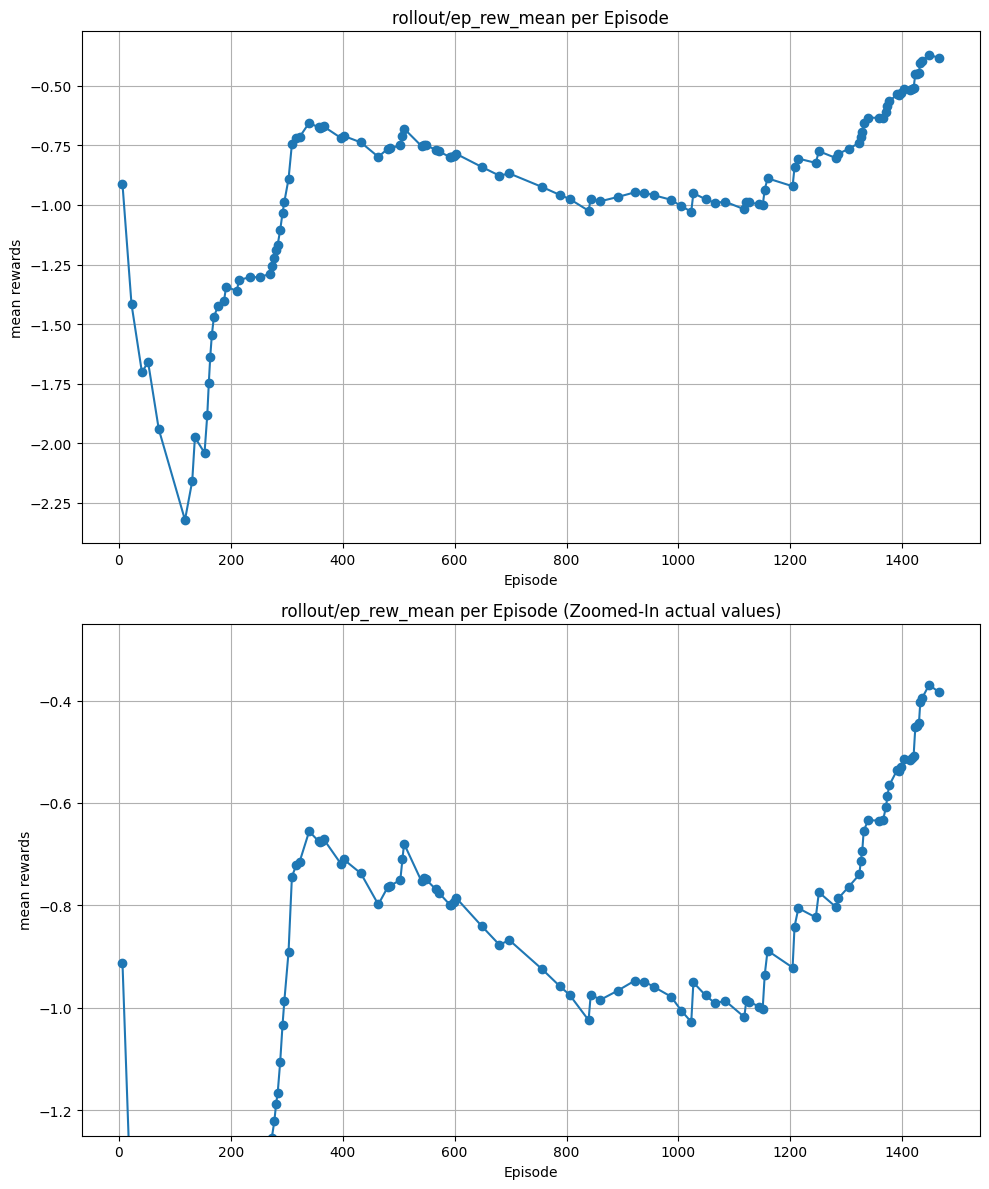

In [2]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_12"
event_file_name = "events.out.tfevents.1714165227.e7c5f58cd75a.256.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'rollout/ep_rew_mean'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot) 

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step / 34 for event in scalar_events]
    episode_values = [event.value / 34 for event in scalar_events]

    # Create subplots with two axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the full-size figure
    ax1.plot(episode_steps, episode_values, marker='o', linestyle='-')
    ax1.set_title(f'{tag_to_plot} per Episode')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('mean rewards')
    ax1.grid(True)

    # Zoomed-in plot on y-axis
    ax2.plot(episode_steps, episode_values, marker='o', linestyle='-')
    ax2.set_title(f'{tag_to_plot} per Episode (Zoomed-In actual values)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('mean rewards')
    ax2.grid(True)
    ax2.set_ylim(-1.25, -0.25)  # Set y-axis limit for zoomed-in plot

    # Adjust layout and display plots
    plt.tight_layout()
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


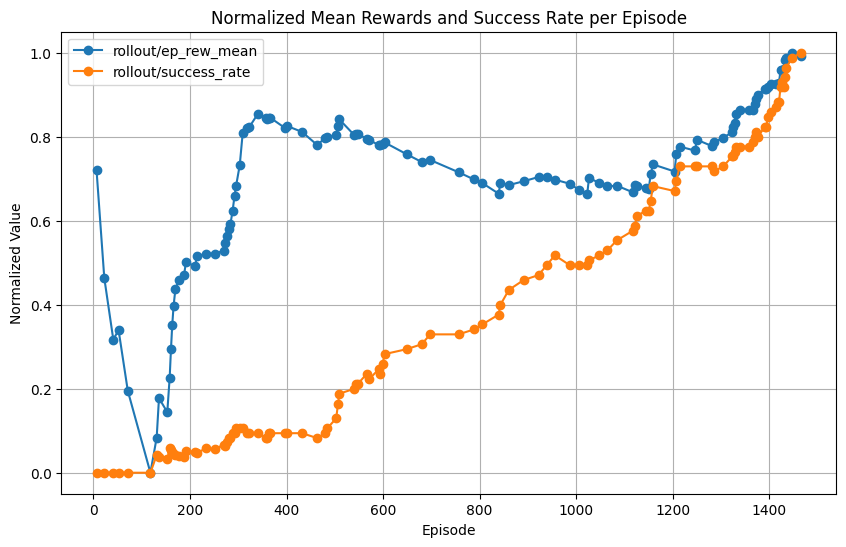

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_12"
event_file_name = "events.out.tfevents.1714165227.e7c5f58cd75a.256.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tags for the scalar values to plot
tags_to_plot = ['rollout/ep_rew_mean', 'rollout/success_rate']

# Check if the specified tags exist in the event file
tags = event_acc.Tags()

# Check if all specified tags are found in the event file
if all(tag in tags['scalars'] for tag in tags_to_plot):
    plt.figure(figsize=(10, 6))

    for tag_to_plot in tags_to_plot:
        # Extract scalar events for the specified tag
        scalar_events = event_acc.Scalars(tag_to_plot)

        # Extract episode steps and values for the specified tag
        episode_steps = [event.step / 34 for event in scalar_events]
        episode_values = [event.value / 34 for event in scalar_events]

        # Normalize values between 0 and 1
        normalized_values = (episode_values - np.min(episode_values)) / (np.max(episode_values) - np.min(episode_values))

        # Plot the normalized scalar value per episode
        plt.plot(episode_steps, normalized_values, marker='o', linestyle='-', label=tag_to_plot)

    plt.title('Normalized Mean Rewards and Success Rate per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Normalized Value')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    missing_tags = [tag for tag in tags_to_plot if tag not in tags['scalars']]
    print(f"Tags '{', '.join(missing_tags)}' not found in the event file.")


### Impact of Changing tau:
Increasing tau from 0.05 to 0.1 means that the target networks will be updated more rapidly towards the current networks.
A higher value of tau leads to more aggressive updates of the target networks, potentially resulting in faster convergence during training.
It is what observe here as we increased tau to double its value and we introduced instability and oscillations in the learning process, which led to more volatile and rapid updates of the target networks.

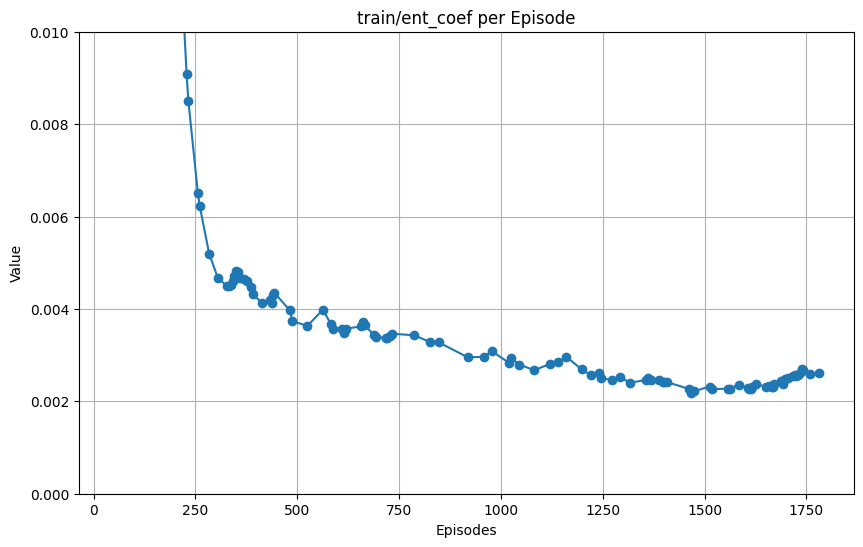

In [4]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_12"
event_file_name = "events.out.tfevents.1714165227.e7c5f58cd75a.256.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/ent_coef')
tag_to_plot = 'train/ent_coef'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step / 28 for event in scalar_events]  # Divide episode steps by 8
    episode_values = [event.value for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Value')
    plt.grid(True)

    # Set y-axis limits to zoom in to values between 0 and 0.01
    plt.ylim(0, 0.01)

    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


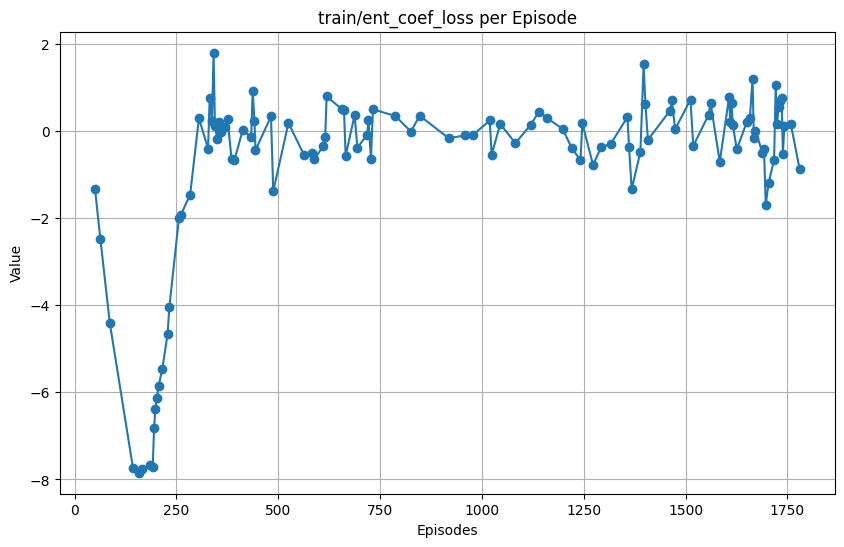

In [9]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_12"
event_file_name = "events.out.tfevents.1714165227.e7c5f58cd75a.256.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/ent_coef')
tag_to_plot = 'train/ent_coef_loss'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step/28  for event in scalar_events]  # Divide episode steps by 8
    episode_values = [event.value for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Value')
    plt.grid(True)



    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


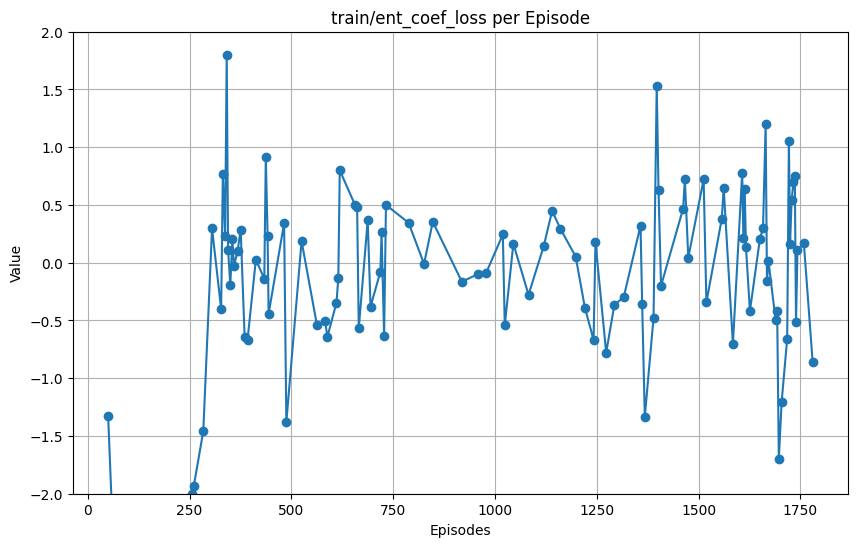

In [7]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_12"
event_file_name = "events.out.tfevents.1714165227.e7c5f58cd75a.256.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/ent_coef')
tag_to_plot = 'train/ent_coef_loss'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step/28  for event in scalar_events]  # Divide episode steps by 8
    episode_values = [event.value for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Value')
    plt.grid(True)

    # Set y-axis limits to zoom in to values between 0 and 0.01
    plt.ylim(-2, 2)

    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


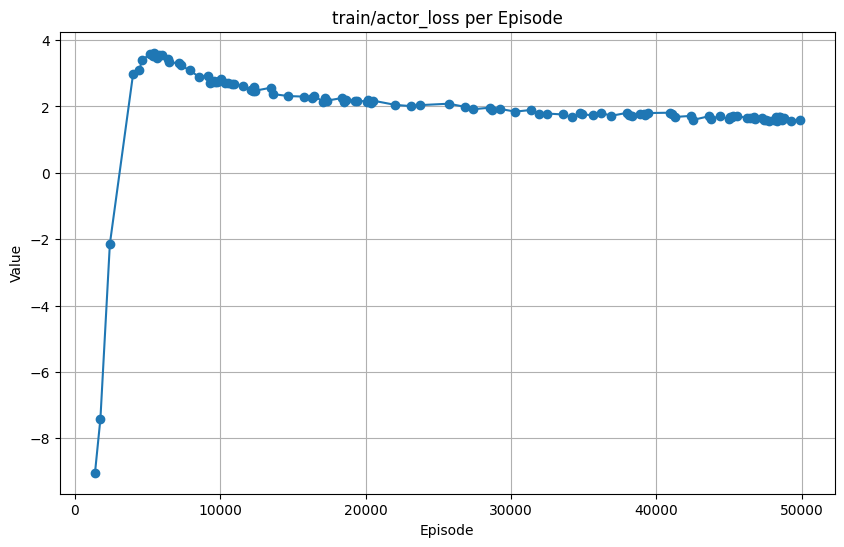

In [5]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_12"
event_file_name = "events.out.tfevents.1714165227.e7c5f58cd75a.256.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'train/actor_loss'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step for event in scalar_events]
    episode_values = [event.value for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


In [ ]:
!pip install --upgrade jupyter
!pip install --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install --upgrade tqdm


In [6]:
#@title Visualize a few episodes

N_EPISODES = 12  # @param {type: "integer"}

env = gym.make('parking-v0', render_mode='rgb_array')
env = record_videos(env)
for episode in trange(N_EPISODES, desc="Test episodes"):
    obs, info = env.reset()
    done = truncated = False
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

Test episodes:   0%|          | 0/12 [00:00<?, ?it/s]

Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4




t:  98%|█████████▊| 86/88 [00:00<00:00, 160.59it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4




t:  94%|█████████▎| 203/217 [00:01<00:00, 170.12it/s, now=None]
                                                               

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4




t:  87%|████████▋ | 33/38 [00:00<00:00, 164.76it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4




t:  73%|███████▎  | 41/56 [00:00<00:00, 204.50it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4




t:  82%|████████▏ | 36/44 [00:00<00:00, 178.81it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4




t:  83%|████████▎ | 54/65 [00:00<00:00, 151.06it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4




t:  82%|████████▏ | 51/62 [00:00<00:00, 147.25it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4




t:  74%|███████▍  | 37/50 [00:00<00:00, 184.73it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4




t:  96%|█████████▌| 93/97 [00:00<00:00, 174.29it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4




t:  56%|█████▌    | 23/41 [00:00<00:00, 226.72it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4




t:  72%|███████▏  | 34/47 [00:00<00:00, 165.98it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4




t:  91%|█████████▏| 75/82 [00:00<00:00, 157.87it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4


## pip install moviepy